In [1]:
import glob
import os
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.trials import align_trials, select_trials
import pandas as pd
from scipy import stats
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
seed = 1997

In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
def get_selectivity_info(neu:NeuronData):

    res = {}
    res["nid"] = neu.get_neuron_id()

    samples = [11, 15, 51, 55, 0]
    for inout in ['in','out']:
        mask = getattr(neu,'mask_'+inout)
        sp = getattr(neu,'sample_on_'+inout)
        sp = firing_rate.moving_average(data=sp, win=100, step=1)[:, 300:]
        sample_id = neu.sample_id[mask]
        sp_samples = select_trials.get_sp_by_sample(sp, sample_id, samples)
        o1 = np.concatenate((sp_samples["11"], sp_samples["15"]))
        o5 = np.concatenate((sp_samples["51"], sp_samples["55"]))
        c1 = np.concatenate((sp_samples["11"], sp_samples["51"]))
        c5 = np.concatenate((sp_samples["15"], sp_samples["55"]))
        sample = np.concatenate(
            (sp_samples["11"], sp_samples["15"], sp_samples["51"], sp_samples["55"])
        )
        n0 = sp_samples["0"]
        # Check selectivity and latency
        color_lat, color_score = smetrics.get_selectivity(c1, c5, win=75,scores=True)
        color_selec = np.nan if np.isnan(color_lat) else "c1" if color_score[color_lat] > 0 else "c5"
        orient_lat, orient_score = smetrics.get_selectivity(o1, o5, win=75,scores=True)
        orient_selec =  np.nan if np.isnan(orient_lat) else "o1" if orient_score[orient_lat] > 0 else "o5" 
        neutral_lat, neutral_score = smetrics.get_selectivity(sample, n0, win=75,scores=True)
        neutral_selec = np.nan if np.isnan(neutral_lat) else "NN" if neutral_score[neutral_lat] > 0 else "N" 
        
        res["color_lat_" + inout] = color_lat
        res["color_selec_" + inout] = color_selec
        res["color_score_" + inout] = color_score
        res["orient_lat_" + inout] = orient_lat
        res["orient_selec_" + inout] = orient_selec
        res["orient_score_" + inout] = orient_score
        res["neutral_lat_" + inout] = neutral_lat
        res["neutral_selec_" + inout] = neutral_selec
        res["neutral_score_" + inout] = neutral_score

    return res

In [4]:
def get_neu_align (path,params,sp_sample=False):

    neu = NeuronData.from_python_hdf5(path)
    for it in params:
        sp, mask = neu.align_on(
                select_block=it["select_block"],
                select_pos=it["inout"],
                event=it["event"],
                time_before=it["time_before"],
                error_type=0,
            )
        endt=it['time_before']+it['end']
        stt=it['time_before']+it['st']
        setattr(neu, it['sp'], np.array(sp[:,:endt],dtype=it["dtype_sp"]))
        setattr(neu, it['mask'], np.array(mask,dtype=it["dtype_mask"]))
    
    if ~sp_sample: setattr(neu, 'sp_samples', np.array([]))

    return neu

In [10]:
# Define parameters
areas = ["lip"]
subject = "Riesling"
# paths
filepaths = {
    "lip": "D:/data/session_struct/lip/neurons/",
    "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}

for area in areas:
    print(area)
    path = filepaths[area]
    neu_path = path + "*neu.h5"
    path_list = glob.glob(neu_path)

lip


In [11]:
params =[{'inout':'in','sp':'sample_on_in','mask':'mask_in','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool},
         {'inout':'out','sp':'sample_on_out','mask':'mask_out','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool}]

In [12]:
population = Parallel(n_jobs=-1)(
    delayed(get_neu_align)(neu,params) for neu in tqdm(path_list[:10])
)

100%|██████████| 10/10 [00:00<00:00, 67.39it/s]


In [13]:
comment = "{'inout':'in','sp':'sample_on_in','mask':'mask_in','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool},{'inout':'out','sp':'sample_on_out','mask':'mask_out','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool}"

In [14]:
population = PopulationData(population, comment=comment)

In [31]:
population.to_python_hdf5('test2.h5')

In [9]:
popu=PopulationData.from_python_hdf5('test2.h5')

In [10]:
popu.population[0].__dict__.keys()

dict_keys(['date_time', 'subject', 'area', 'experiment', 'recording', 'sp_samples', 'cluster_id', 'cluster_ch', 'cluster_group', 'cluster_number', 'cluster_array_pos', 'cluster_depth', 'block', 'trial_error', 'code_samples', 'code_numbers', 'position', 'pos_code', 'sample_id', 'test_stimuli', 'test_distractor', 'mask_in', 'mask_out', 'sample_on_in', 'sample_on_out'])

In [15]:
a=get_selectivity_info(population.population[5])

In [36]:
a['orient_score_in']

array([-0.08, -0.06, -0.08, ...,  0.24,  0.22,  0.  ])

In [16]:
df_selectivity = population.execute_function(get_selectivity_info, n_jobs=-1, ret_df=True)


100%|██████████| 10/10 [00:00<00:00, 3182.08it/s]


In [17]:
df_selectivity['neutral_score_in'].values

array([nan, nan, nan,
       array([ 0.02,  0.02,  0.02, ..., -0.1 , -0.12,  0.  ]),
       array([0.02, 0.02, 0.02, ..., 0.1 , 0.1 , 0.  ]),
       array([ 0.08,  0.08,  0.08, ..., -0.02, -0.02,  0.  ]), nan, nan,
       array([-0.02, -0.02, -0.02, ..., -0.04, -0.04,  0.  ]), nan],
      dtype=object)

In [18]:
df_selectivity.to_csv("population_selectivity2_" + area + ".csv", index=False)

c:\Users\camil\.virtualenvs\Users-zKW_FhGB\lib\site-packages\pandas\core\missing.py:124: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask[arr_mask] = arr[arr_mask] == x


In [18]:
df_fr=pd.read_csv('C:/Users/camil/Documents/int/code/Users/losadac/data_stats/neurons/res/population_fr_lip.csv')#.drop('Unnamed: 0', axis=1) 
#df_selectivity=pd.read_csv("population_selectivity2_" + area + ".csv")

In [19]:
df_sel1=pd.merge(df_selectivity, df_fr, left_on='nid',right_on='nid')
df_sel_in=df_sel1[df_sel1['fr_sampleNNin']>=1]
df_sel_out=df_sel1[df_sel1['fr_sampleNNout']>=1]

c:\Users\camil\.virtualenvs\Users-zKW_FhGB\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'orient_lat_out')

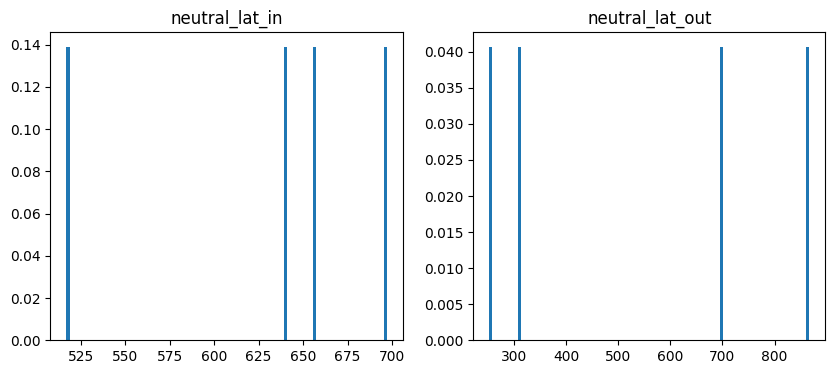

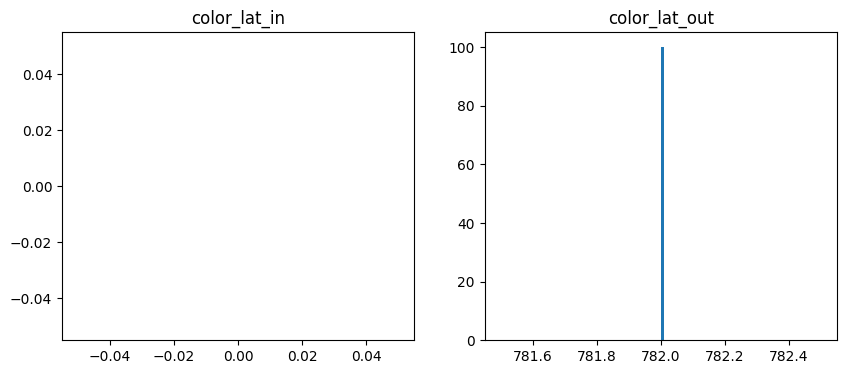

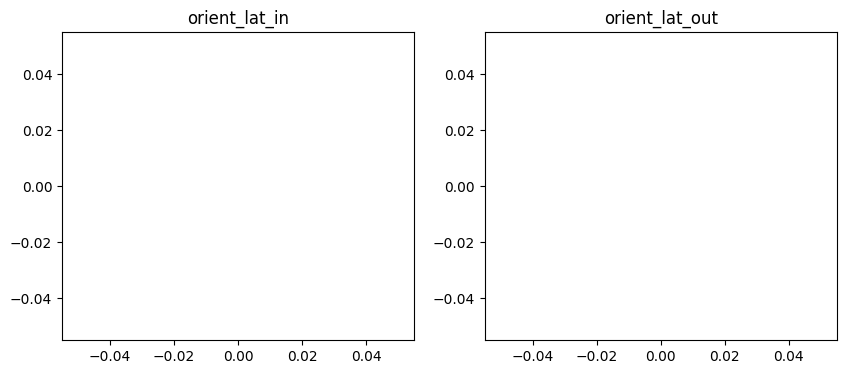

In [20]:
f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['neutral_lat_in'].notna()]['neutral_lat_in']-200,density=True,bins=100) 
ax[0].set_title('neutral_lat_in')
ax[1].hist(df_sel_out[df_sel_out['neutral_lat_out'].notna()]['neutral_lat_out']-200,density=True,bins=100) 
ax[1].set_title('neutral_lat_out')

f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['color_lat_in'].notna()]['color_lat_in']-200,density=True,bins=100) 
ax[0].set_title('color_lat_in')
ax[1].hist(df_sel_out[df_sel_out['color_lat_out'].notna()]['color_lat_out']-200,density=True,bins=100) 
ax[1].set_title('color_lat_out')

f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['orient_lat_in'].notna()]['orient_lat_in']-200,density=True,bins=100) 
ax[0].set_title('orient_lat_in')
ax[1].hist(df_sel_out[df_sel_out['orient_lat_out'].notna()]['orient_lat_out']-200,density=True,bins=100) 
ax[1].set_title('orient_lat_out')

In [63]:
f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['neutral_lat_in'].notna()]['neutral_lat_in']-200,density=True,bins=100) 
ax[0].set_title('neutral_lat_in')
ax[1].hist(df_sel_out[df_sel_out['neutral_lat_out'].notna()]['neutral_lat_out']-200,density=True,bins=100) 
ax[1].set_title('neutral_lat_out')

f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['color_lat_in'].notna()]['color_lat_in']-200,density=True,bins=100) 
ax[0].set_title('color_lat_in')
ax[1].hist(df_sel_out[df_sel_out['color_lat_out'].notna()]['color_lat_out']-200,density=True,bins=100) 
ax[1].set_title('color_lat_out')

f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['orient_lat_in'].notna()]['orient_lat_in']-200,density=True,bins=100) 
ax[0].set_title('orient_lat_in')
ax[1].hist(df_sel_out[df_sel_out['orient_lat_out'].notna()]['orient_lat_out']-200,density=True,bins=100) 
ax[1].set_title('orient_lat_out')

In [41]:
import ast

In [21]:
df_sel_in[df_sel_in['neutral_lat_in'].notna()]['neutral_score_in'].values

array([array([ 0.02,  0.02,  0.02, ..., -0.1 , -0.12,  0.  ]),
       array([0.02, 0.02, 0.02, ..., 0.1 , 0.1 , 0.  ]),
       array([ 0.08,  0.08,  0.08, ..., -0.02, -0.02,  0.  ]),
       array([-0.02, -0.02, -0.02, ..., -0.04, -0.04,  0.  ])],
      dtype=object)

In [51]:
df_sel_in[df_sel_in['neutral_lat_in'].notna()]['neutral_score_in'][4].strip('["')

'-0.02  0.   -0.02 ...  0.04  0.04  0.  ]'

In [22]:
df_sel_in

,nid,color_lat_in,color_selec_in,color_score_in,orient_lat_in,orient_selec_in,orient_score_in,neutral_lat_in,neutral_selec_in,neutral_score_in,...,spfix_bl_ratio_delay1Nout,spmax_bl_ratio_delay1Nout,p_maxfr_delay1Nout,fr_delay2Nout,maxfrlat_delay2Nout,maxfr_delay2Nout,maxfr200_delay2Nout,spfix_bl_ratio_delay2Nout,spmax_bl_ratio_delay2Nout,p_maxfr_delay2Nout
0,mua3LIP2023-10-18_10-57-56Riesling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.666504,0.692383,0.983655,2.315521,50.0,3.705978,2.516551,0.717773,0.666504,0.983638
1,mua4LIP2023-10-18_10-57-56Riesling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.899902,1.099609,0.805549,4.074097,80.0,5.558014,3.995724,1.174805,1.075195,0.850146
3,mua6LIP2023-10-18_10-57-56Riesling,NaN,NaN,NaN,NaN,NaN,NaN,840.0,N,"[0.020000000000000018, 0.020000000000000018, 0...",...,1.328125,1.658203,0.001469,12.359619,350.0,15.373230,13.269145,1.658203,1.834961,0.000191
4,mua7LIP2023-10-18_10-57-56Riesling,NaN,NaN,NaN,NaN,NaN,NaN,897.0,NN,"[0.020000000000000018, 0.020000000000000018, 0...",...,0.184570,0.333252,0.000002,3.936768,153.0,5.371094,4.656496,0.315430,0.315430,0.000001
5,good1LIP2023-10-18_10-57-56Riesling,NaN,NaN,NaN,NaN,NaN,NaN,857.0,N,"[0.08000000000000007, 0.08000000000000007, 0.0...",...,0.790527,0.790527,0.419375,3.379822,184.0,4.444122,3.564749,0.883789,0.930176,0.519409
8,mua10LIP2023-10-18_10-57-56Riesling,NaN,NaN,NaN,NaN,NaN,NaN,717.0,N,"[-0.020000000000000018, -0.020000000000000018,...",...,3.199219,3.800781,0.074810,1.574516,186.0,2.964020,2.079973,4.398438,4.800781,0.019604
9,mua11LIP2023-10-18_10-57-56Riesling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.700195,2.000000,0.077033,1.250267,7.0,2.222061,1.565034,1.599609,1.700195,0.204976
